# Chapter 5

In [2]:
import os
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats
from theano import shared
# import sns

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [3]:
%config Inline.figure_format = 'retina'
az.style.use('arviz-darkgrid')
np.random.seed(0)

In [4]:
# Load data
data = pd.read_csv(os.path.join("Data", "WaffleDivorce.csv"), delimiter=";")

In [5]:
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [6]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series

def unstandardize(std_series, original_series):
    """Given an input series restandardize"""
    unstandardize = std_series*original_series.std() + original_series.mean()
    return unstandardize

#### Code 5.1

In [7]:
# Standard regressors and target
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

#### Code 5.2

In [8]:
data["MedianAgeMarriage"].std()

1.2436303013880823

#### Code 5.3

In [9]:
with pm.Model() as divorce_model_age:
    a = pm.Normal("a", 0, .2)
    bA = pm.Normal("bA", 0, .5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a+bA*data["MedianAgeMarriage_std"])

    divorce_rate_std = pm.Normal("divorce_rate_std", mu=mu, sd=sigma, observed = data["Divorce_std"].values)
    prior_samples = pm.sample_prior_predictive()
    trace_divorce_age = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1689.69draws/s]


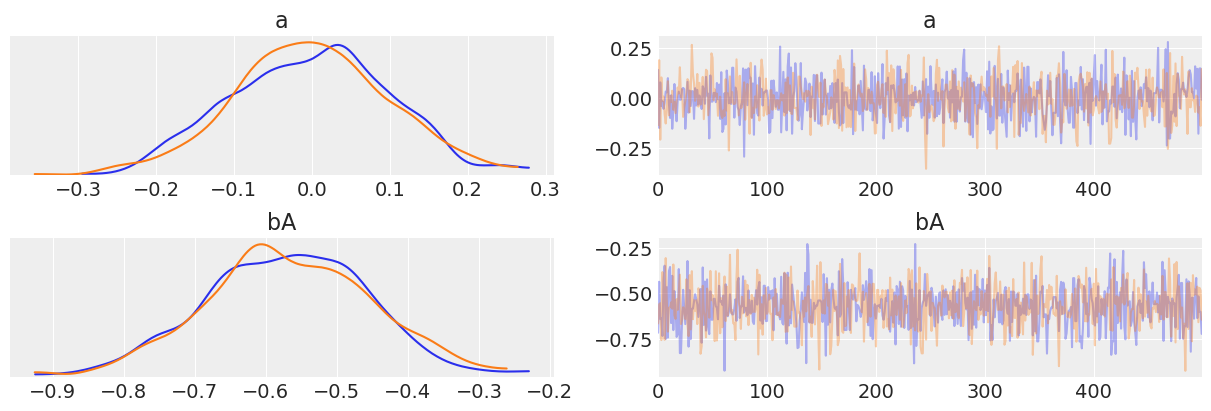

In [10]:
az.plot_trace(trace_divorce_age, var_names = ["a", "bA"]);

#### Code 5.4

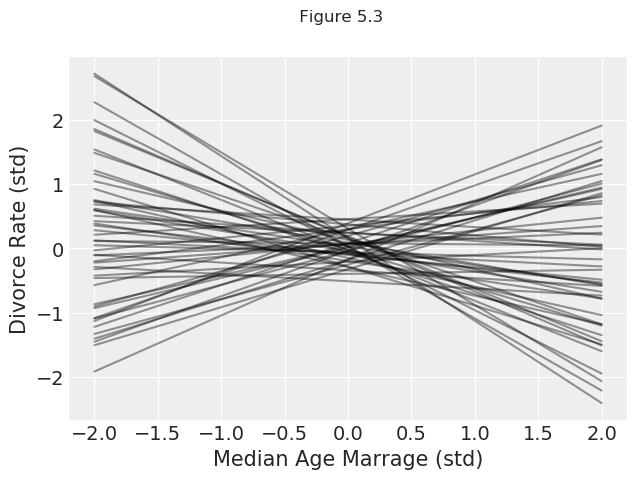

In [11]:
fig, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, ba in zip(prior_samples["a"][:50], prior_samples["bA"][:50]):
    y = a + ba*x 
    ax.plot(x, y, c="black", alpha=.4)
    
ax.set_xlabel("Median Age Marrage (std)")
ax.set_ylabel("Divorce Rate (std)")
fig.suptitle(" Figure 5.3");

#### Code 5.5

In [12]:
trace_divorce_age["bA"].shape

(1000,)

In [13]:
# This is equivalent of link function

age_std_seq = np.linspace(-3, 3.2, 30)

# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
trace_divorce_age_thinned = trace_divorce_age[::10]
mu_pred = np.zeros((len(age_std_seq), len(trace_divorce_age_thinned) * trace_divorce_age_thinned.nchains))

for i, age_std in enumerate(age_std_seq):
    mu_pred[i] = trace_divorce_age_thinned["a"] + trace_divorce_age_thinned["bA"]*age_std

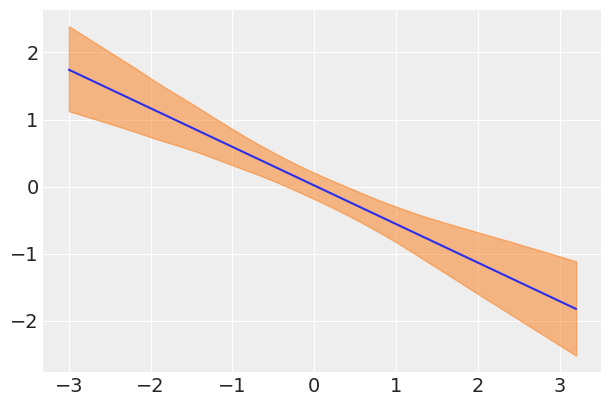

In [14]:
# Now I need to take average of mu and plot
# I should get 30 averages, one for each x
mu_mean = mu_pred.mean(axis=1)
plt.plot(age_std_seq, mu_mean)

# This is equivalent of Percent Interval
az.plot_hpd(age_std_seq, mu_pred.T);

#### 5.6

In [15]:
with pm.Model() as divorce_model_marriage:
    a = pm.Normal("a", 0, .2)
    bM = pm.Normal("bM", 0, .5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a+bM*data["Marriage_std"])

    divorce_rate_std = pm.Normal("divorce_rate_std", mu=mu, sd=sigma, observed = data["Divorce_std"].values)
    prior_samples = pm.sample_prior_predictive()
    trace_divorce_marriage = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, a]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 847.24draws/s] 


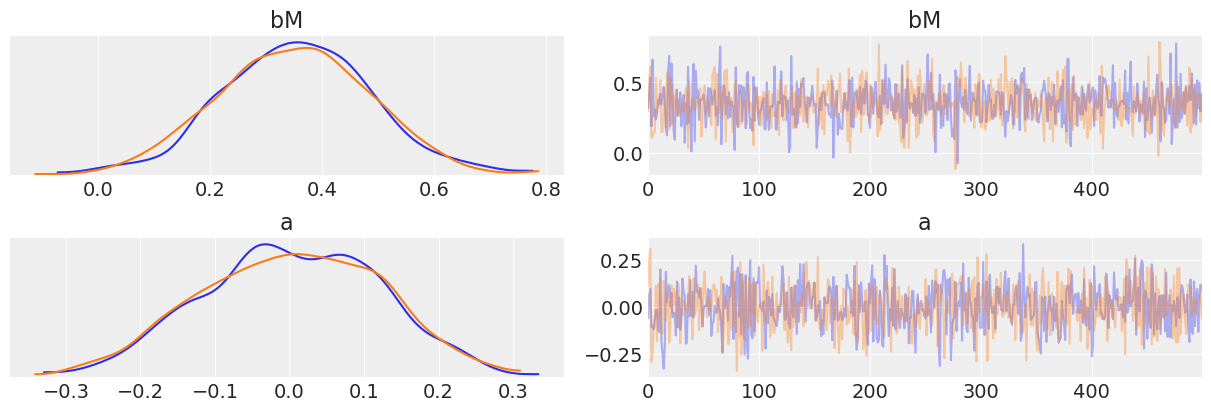

In [16]:
az.plot_trace(trace_divorce_marriage, var_names=["bM", "a"]);

#### 5.7

#### 5.8

#### 5.9

#### 5.13

In [17]:
with pm.Model() as divorce_model_marriage_age:
    a = pm.Normal("a", 0, .2)
    bA = pm.Normal("bA", 0, .5)
    bM = pm.Normal("bM", 0, .5)

    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a+bM*data["Marriage_std"] + bA*data["MedianAgeMarriage_std"])

    divorce_rate_std = pm.Normal("divorce_rate_std", mu=mu, sd=sigma, observed = data["Divorce_std"].values)
    prior_samples = pm.sample_prior_predictive()
    trace_divorce_marriage_age = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, bA, a]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1044.50draws/s]


In [18]:
pm.summary(trace_divorce_marriage_age, var_names=["a", "bM", "bA", "sigma"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.005858,0.096742,0.003124,-0.185885,0.197501,827.340290,1.001299
bM,-0.060471,0.150429,0.005589,-0.375827,0.208550,776.246993,1.000022
bA,-0.605774,0.155065,0.005616,-0.876108,-0.275844,817.973940,0.999942
sigma,0.828467,0.088139,0.002878,0.672774,1.003289,952.490175,0.999336


#### 5.11

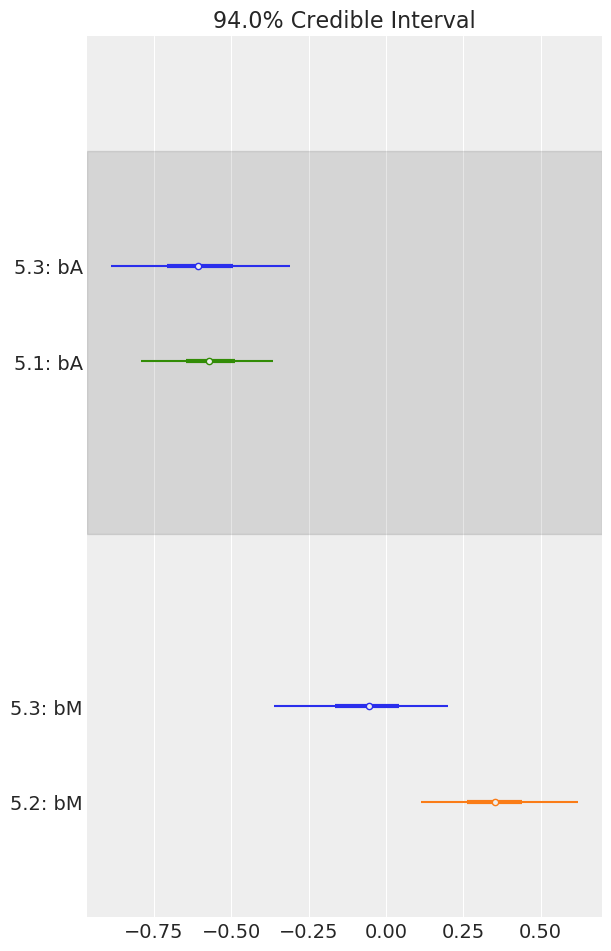

In [19]:
pm.plot_forest([trace_divorce_marriage_age, trace_divorce_marriage, trace_divorce_age,], model_names=["5.3", "5.2", "5.1"], var_names=["bA", "bM"], combined=True);

#### 5.12

In [20]:
N = 50
age = stats.norm().rvs(N)
mar = stats.norm(-age).rvs(N)
div = stats.norm(age).rvs(N)

#### 5.13

In [21]:
 with pm.Model() as model_marriage_age:
    a = pm.Normal("a", 0, .2)
    bAM = pm.Normal("bAM", 0, .5)
    sigma = pm.Exponential("sigma", 1)
    
    mu = pm.Deterministic("mu", a+bAM*data["MedianAgeMarriage_std"])

    marriage_std = pm.Normal("_std", mu=mu, sd=sigma, observed = data["Marriage_std"].values)
    prior_samples = pm.sample_prior_predictive()
    trace_marriage_age = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAM, a]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1201.11draws/s]


#### 5.14

In [23]:
mu_pred_marriage_mean = trace_marriage_age["mu"].mean(axis=0)
residuals = data["Marriage_std"] - mu_pred_marriage_mean

#### 5.15
Something is worng iwth tis plot

In [24]:
# Get mean of trace
mu_pred_divorce_marriage_age = trace_divorce_marriage_age["mu"].mean(axis=0)

In [25]:
# We can skip most of the code with the posterior predictive plot functionality in pymc3
with divorce_model_marriage_age:
    ppc_marriage_age = pm.sample_posterior_predictive(trace_divorce_marriage_age, samples=1000)

mean_posterior_predictive = ppc_marriage_age['divorce_rate_std'].mean(axis=0)

# percentiles = np.percentile(ppc_marriage_age['divorce_rate_std'], [5.5, 94.5], axis=1)
mu_hpd = az.hpd(ppc_marriage_age['divorce_rate_std'], credible_interval=0.89)

100%|██████████| 1000/1000 [00:02<00:00, 375.02it/s]


#### 5.16

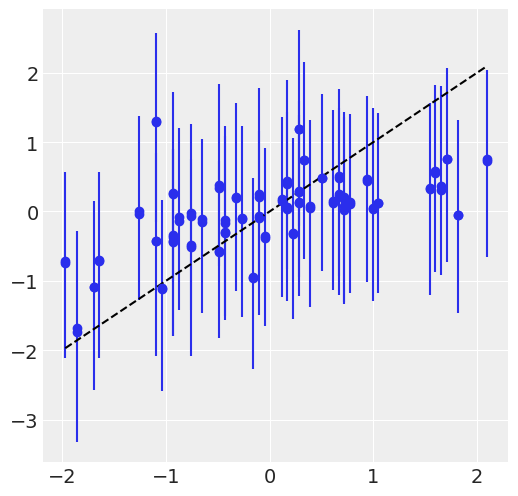

In [26]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(data["Divorce_std"].values, mu_pred_divorce_marriage_age)
plt.errorbar(data["Divorce_std"].values, mean_posterior_predictive, yerr=np.abs(mean_posterior_predictive - mu_hpd.T) , fmt='C0o')

min_x, max_x = data["Divorce_std"].min(), data["Divorce_std"].max()
plt.plot([min_x, max_x], [min_x, max_x], 'k--');


#### 5.18

In [27]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)
d = pd.DataFrame([y, x_real, x_spur]).T

sns.pairplot(d);

NameError: name 'sns' is not defined

#### 5.19

In [70]:
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

# Use Theano shared variables so we can change them later
marriage_shared = shared(data["Marriage_std"].values)
age_shared = shared(data["MedianAgeMarriage_std"].values)

with pm.Model() as m5_3_A:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, .5)
    bM = pm.Normal("bM", 0, .5)

    a = pm.Normal("a", 0, .2)
    mu = pm.Deterministic("mu", a + bA*age_shared + bM*marriage_shared)
    divorce = pm.Normal("divorce", mu, sigma, observed=data["Divorce_std"])
    
    m5_3_A_divorce_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bM, bA, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 901.51draws/s] 


In [71]:
# Making this a shared variable lets us manipulate it later

with pm.Model() as m5_3_A_M:
   
    # A -> M
    sigma_M = pm.Exponential("sigma_m", 1)
    bAM = pm.Normal("bAM", 0, .5)
    aM = pm.Normal("aM", 0, .2)
    mu_M = pm.Deterministic("mu_m", aM + bAM*age_shared)
    marriage = pm.Normal("marriage", mu_M, sigma_M, observed=data["Marriage_std"])
    
    m5_3_M_marriage_trace = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [aM, bAM, sigma_m]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1091.85draws/s]


#### 5.20

In [ ]:
A_seq = np.linspace(-2, 2, 30)
A_seq.shape

#### 5.21
No idea how to do counterfactual correctly

In [51]:
# With PyMC3 we have to simulate in each model separately

# Simulate the marriage rates at each age first
age_shared.set_value(A_seq)

with m5_3_A_M:
    m5_3_M_marriage = pm.sample_posterior_predictive(m5_3_M_marriage_trace, samples=1)
    
marriage.shared(m5_3_M_marriage["marriage"]




100%|██████████| 1/1 [00:00<00:00, 178.60it/s]


(1, 30)

#### 5.22?

#### 5.23?

#### 5.24?

In [62]:
# Set values for marriage counterfactual
marriage_counter_factual_x = np.linspace(-2, 2, 30)
marriage_shared = shared(marriage_counter_factual_x)

# Fix age to zero
age_shared = shared(np.zeros(30))

with m5_3_A:
    marriage_divorce_counterfactual_ppc = pm.sample_posterior_predictive(m5_3_A_divorce_trace)


100%|██████████| 1000/1000 [00:01<00:00, 641.29it/s]


ValueError: x and y must have same first dimension, but have shapes (30,) and (50,)

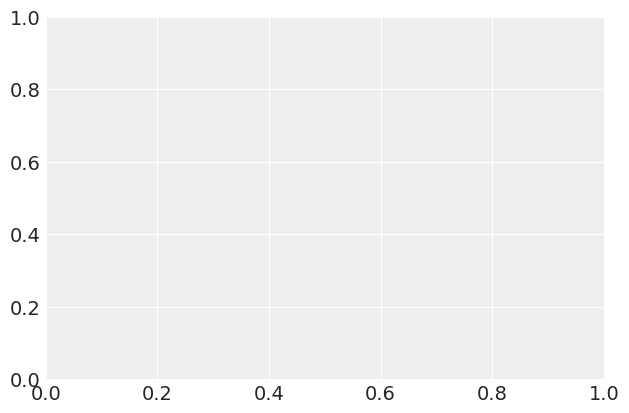

In [63]:
fig, ax = plt.subplots()
divorce_means = marriage_divorce_counterfactual_ppc["divorce"].mean(axis=0)

ax.plot(marriage_counter_factual_x, divorce_means)

#### 5.25

In [ ]:
A_seq = np.linspace(-2, 2, 30)

#### 5.26

In [72]:
# Get the samples from Age Marriage model first
with m5_3_A_M:
    m5_3_M_marriage = pm.sample_posterior_predictive(m5_3_M_marriage_trace, var_names=["sigma_m", "aM", "bAM"])
    

100%|██████████| 1000/1000 [00:00<00:00, 16358.57it/s]


KeyError: 'sigma_M'

In [136]:
# Working!!!
stats.norm(loc=[[1,2,5],[3,4,6]], scale=.0001).rvs((1,2,3))


#stats.norm(loc=[[1,2],[3,4]], scale=.01).rvs((1,2, 1000))

# stats.norm(loc=[1,2], scale=[2, .00001]).rvs((1000,2))

array([[[1.000279  , 1.99994379, 5.00004671],
        [3.00001955, 4.00006719, 6.00009568]]])

In [129]:
marriage = m5_3_M_marriage["bAM"]
np.outer(marriage,[1,2])


array([[-0.6548331 , -1.3096662 ],
       [-0.79546119, -1.59092238],
       [-0.71700286, -1.43400573],
       ...,
       [-0.46949757, -0.93899514],
       [-0.73463562, -1.46927123],
       [-0.65325268, -1.30650536]])

In [121]:
marriage

(1000,)

In [135]:
#marriage_mu_counterfactual = m5_3_M_marriage["aM"] + m5_3_M_marriage["bAM"] 
marriage_mu_counterfactual = np.outer(m5_3_M_marriage["aM"] + m5_3_M_marriage["bAM"], A_seq)
marriage_mu_counterfactual.shape

(1000, 30)

In [150]:
M_sim = stats.norm(loc=marriage_mu_counterfactual.T, scale=m5_3_M_marriage["sigma_m"]).rvs()

# Each row age counter factual value and each column is simulated marriage rate at that age
M_sim.shape

(30, 1000)

#### 5.23

In [167]:
with m5_3_A:
    m5_3_M_divorce = pm.sample_posterior_predictive(m5_3_A_divorce_trace, var_names=["sigma", "bM", "bA", "a"], samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 11192.57it/s]


In [176]:
D_sim = np.zeros((30, 1000))
a, bM, bA = m5_3_M_divorce["a"], m5_3_M_divorce["bM"], m5_3_M_divorce["bA"]

for i, age_counterfactual in enumerate(A_seq):
    divorce_mu_counterfactual = a + bA*age_counterfactual + bM*M_sim[i,:]
    samples = stats.norm(divorce_mu_counterfactual, m5_3_M_divorce["sigma"]).rvs()
    D_sim[i,:] = samples


#### Bonus: Recreate Figure 5.6 

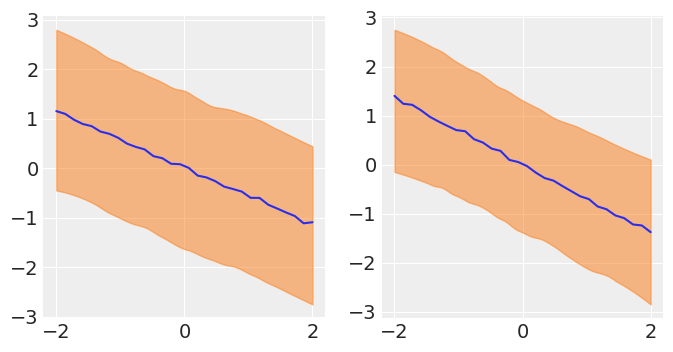

In [184]:
fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[1].plot(A_seq, M_sim.mean(1))
az.plot_hpd(A_seq, M_sim.T, ax=axes[1])

axes[0].plot(A_seq, D_sim.mean(1))
az.plot_hpd(A_seq, D_sim.T, ax=axes[0])

## Extra code
Code that recreates some of the figures whos code isnt included in the book

In [ ]:
# Change domain of vars back to domain of original units
regular_age_seq = unstandardize(age_std_seq, data["MedianAgeMarriage"])
regular_divorce_seq = unstandardize(mu_mean, data["Divorce"])
regular_divorce_seq_pred = unstandardize(mu_pred, data["Divorce"])

In [ ]:
fig, ax = plt.subplots()

ax.scatter(data["MedianAgeMarriage"], data["Divorce"], facecolors='none', edgecolors='b')
ax.set_yticks([13, 10, 6])
ax.set_xticks([23, 26, 29])
ax.plot(regular_age_seq, regular_divorce_seq)
az.plot_hpd(regular_age_seq, regular_divorce_seq_pred.T)